In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
if 'imNum' not in dir():
    imNum = 1   # счётчик для названий картинок
impath = 'trash_img'    # путь к папке, в которой будут сохраняться картинки
#switching latex fonts
plt.rcParams.update({
    "text.usetex" : True,
    "font.family" : "serif",
    "font.serif" : "Computer Modern",
    "text.latex.preamble" : r'\usepackage{amsmath} \usepackage{mathtext} \usepackage[english, russian]{babel}'
})
plt.rcParams.update({
    "figure.figsize": (8, 6),
    'figure.dpi': 200
})

# необходимые функции

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции 
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)  
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(domain, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

def plot_approx(x, y, f, par_names_str, fun_name, yerr=None, visApproxError=True, p0=None):
    if yerr is not None:
        popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True, p0=p0)
    else:
        popt, pcov = curve_fit(f, x, y, p0=p0)
    err = np.sqrt(np.diag(pcov))
    for v, er in zip(popt, err):
        print(v,'+-',er)
    approx_label = f"аппроксимация функцией {fun_name}"
    if (err == np.inf).any():
        print('Аппроксимация не сошлась. Попробуй задать начальные параметры p0')
    else:
        par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
        for i in range(len(par_names)):
            t = par_names[i]
            if len(t) == 2:
                name, units = t
            else:
                name, units = *t, ''
            approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
    teorPoints = 50     
    intent = 0.05   # отступ по бокам от обласи экспериментальных данных
    a, b = x.min(), x.max()
    X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
    plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError and (pcov != np.inf).all():
        nsigma = 2
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")

def make_beautiful_plot(xname, xunit, yname, yunit):
    plt.grid(True, which='minor', linewidth=0.2)
    plt.grid(True, which='major')
    plt.xlabel(fr"{xname}, {xunit}")
    plt.ylabel(fr"{yname}, {yunit}")
    plt.title(fr"{yname}({xname})")
    plt.legend()

In [2]:
#ВВод данных
df = pd.read_excel("hol_efect.ods", engine="odf", sheet_name=0) # для таблиц ods (требуется установка pip install odfpy)
# df = pd.read_excel("measurements.xls")    # excel таблицы
x = df.iloc[:, 0].dropna()
y = df.iloc[:, 1].dropna()
xerr = np.ones_like(x)*0.01
yerr = np.abs(y)*0.10
df.head()

,"Ток через электромагнит, А","Магнитное поле, мТл",Unnamed: 2,"I_M, А","U, мВ","dU, мв",Ток постоянен и равен 24.0 мА,Unnamed: 7,Unnamed: 8,"U, мВ.1",Unnamed: 10,обратной стороной,Unnamed: 12,Перпендикулярно и параллельно полю(пластинка),"I_M, A","U_перп, мВ","U_пар, мВ"
0,0.00,-9.95,NaN,0.00,0.744,NaN,NaN,NaN,NaN,0.739,NaN,(примерно на 0.03 мВ можно уйти в пределах одн...,NaN,ток 10мА,0.00,2.956,2.704
1,0.05,-56.00,NaN,0.05,0.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,2.968,2.718
2,0.10,-107.40,NaN,0.10,0.998,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,0.10,3.030,2.758
3,0.15,-148.10,NaN,0.15,1.236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15,3.105,2.818
4,0.20,-200.00,NaN,0.20,1.572,NaN,NaN,NaN,NaN,1.682,NaN,NaN,NaN,NaN,0.20,3.185,2.888


-907.4958761687243 +- 34.86617312030145
-10.028300643421447 +- 0.9846811615243863


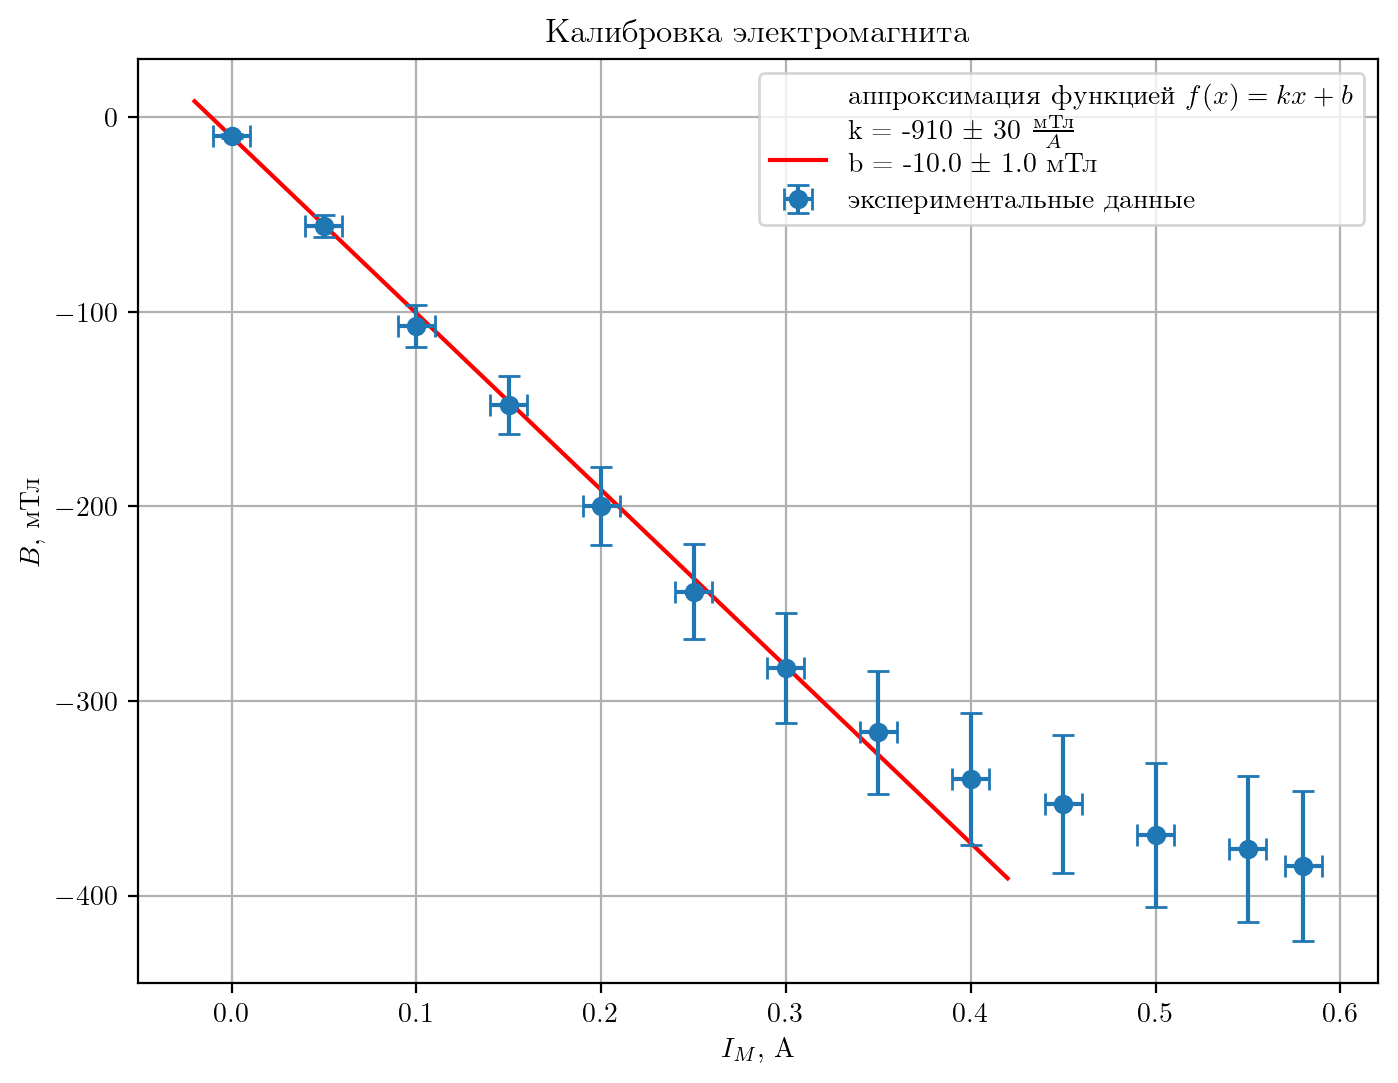

In [18]:
# параметры построения графика и аппроксмации прямой
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = False   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
xname, xunit = r"$I_{M}$", "A"
yname, yunit = r"$B$", "мТл"
par_names_str = fr'''
k, $\frac{{{yunit}}}{{{xunit}}}$
b, {yunit}
'''
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров
# построение графика
filter = x < 0.45
# аппроксимация
plot_approx(x[filter], y[filter], f, par_names_str, fun_name, yerr=yerr[filter], visApproxError=visApproxError)

# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

make_beautiful_plot(xname, xunit, yname, yunit)
plt.title("Калибровка электромагнита")
if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1

#### Следующий график

In [23]:
#ВВод данных
df = pd.read_excel("hol_efect.ods", engine="odf", sheet_name=0) # для таблиц ods (требуется установка pip install odfpy)
# df = pd.read_excel("measurements.xls")    # excel таблицы
B = df.iloc[:, 1].dropna()/1000 # teslas
U = df.iloc[:, 4].dropna()/1000
I = 0.024
y = R = U/I
x = B**2
xerr = x*0.10
yerr = 5e-5*y + np.ones_like(x)*35e-6/I
df.head()

,"Ток через электромагнит, А","Магнитное поле, мТл",Unnamed: 2,"I_M, А","U, мВ","dU, мв",Ток постоянен и равен 24.0 мА,Unnamed: 7,Unnamed: 8,"U, мВ.1",Unnamed: 10,обратной стороной,Unnamed: 12,Перпендикулярно и параллельно полю(пластинка),"I_M, A","U_перп, мВ","U_пар, мВ"
0,0.00,-9.95,NaN,0.00,0.744,NaN,NaN,NaN,NaN,0.739,NaN,(примерно на 0.03 мВ можно уйти в пределах одн...,NaN,ток 10мА,0.00,2.956,2.704
1,0.05,-56.00,NaN,0.05,0.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,2.968,2.718
2,0.10,-107.40,NaN,0.10,0.998,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,0.10,3.030,2.758
3,0.15,-148.10,NaN,0.15,1.236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15,3.105,2.818
4,0.20,-200.00,NaN,0.20,1.572,NaN,NaN,NaN,NaN,1.682,NaN,NaN,NaN,NaN,0.20,3.185,2.888


0.8030266018064994 +- 0.00756979154811294
0.03309672127574432 +- 0.0007002529700478186


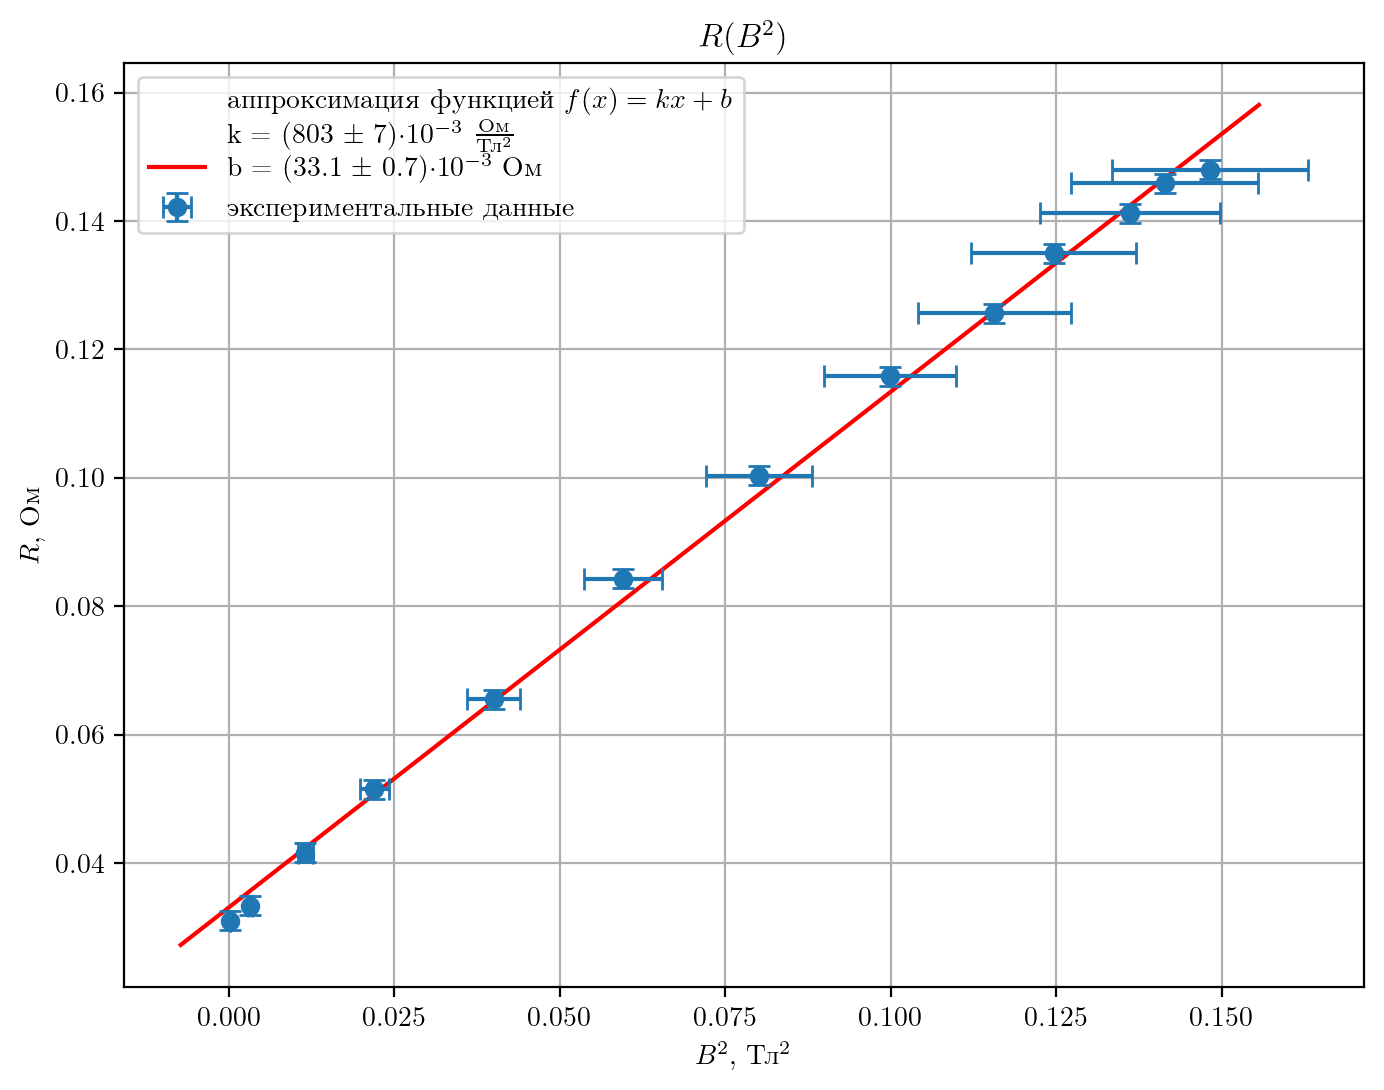

In [26]:
# параметры построения графика и аппроксмации прямой
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = False   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
xname, xunit = r"$B^2$", "$Тл^2$"
yname, yunit = r"$R$", "Ом"
par_names_str = fr'''
k, $\frac{{{yunit}}}{{{xunit.replace('$', '')}}}$
b, {yunit}
'''
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров
# построение графика

# аппроксимация
filter = x*0 < 0.3**2
plot_approx(x[filter], y[filter], f, par_names_str, fun_name, yerr=yerr[filter], visApproxError=visApproxError)

# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

make_beautiful_plot(xname, xunit, yname, yunit)

if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1

#### Следующий график

In [34]:
#ВВод данных
df = pd.read_excel("hol_efect.ods", engine="odf", sheet_name=0) # для таблиц ods (требуется установка pip install odfpy)
# df = pd.read_excel("measurements.xls")    # excel таблицы
B = df.iloc[:, 1].dropna()/1000 # teslas
U = df.iloc[:, 15].dropna()/1000
I = 0.010
y = R = U/I
x = B**2
xerr = x*0.15
yerr = 5e-5*y + np.ones_like(x)*35e-6/U
df.head()

,"Ток через электромагнит, А","Магнитное поле, мТл",Unnamed: 2,"I_M, А","U, мВ","dU, мв",Ток постоянен и равен 24.0 мА,Unnamed: 7,Unnamed: 8,"U, мВ.1",Unnamed: 10,обратной стороной,Unnamed: 12,Перпендикулярно и параллельно полю(пластинка),"I_M, A","U_перп, мВ","U_пар, мВ"
0,0.00,-9.95,NaN,0.00,0.744,NaN,NaN,NaN,NaN,0.739,NaN,(примерно на 0.03 мВ можно уйти в пределах одн...,NaN,ток 10мА,0.00,2.956,2.704
1,0.05,-56.00,NaN,0.05,0.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,2.968,2.718
2,0.10,-107.40,NaN,0.10,0.998,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,0.10,3.030,2.758
3,0.15,-148.10,NaN,0.15,1.236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15,3.105,2.818
4,0.20,-200.00,NaN,0.20,1.572,NaN,NaN,NaN,NaN,1.682,NaN,NaN,NaN,NaN,0.20,3.185,2.888


0.17421980624946215 +- 0.055701021028329
0.12489800603296597 +- 0.005460619118022554


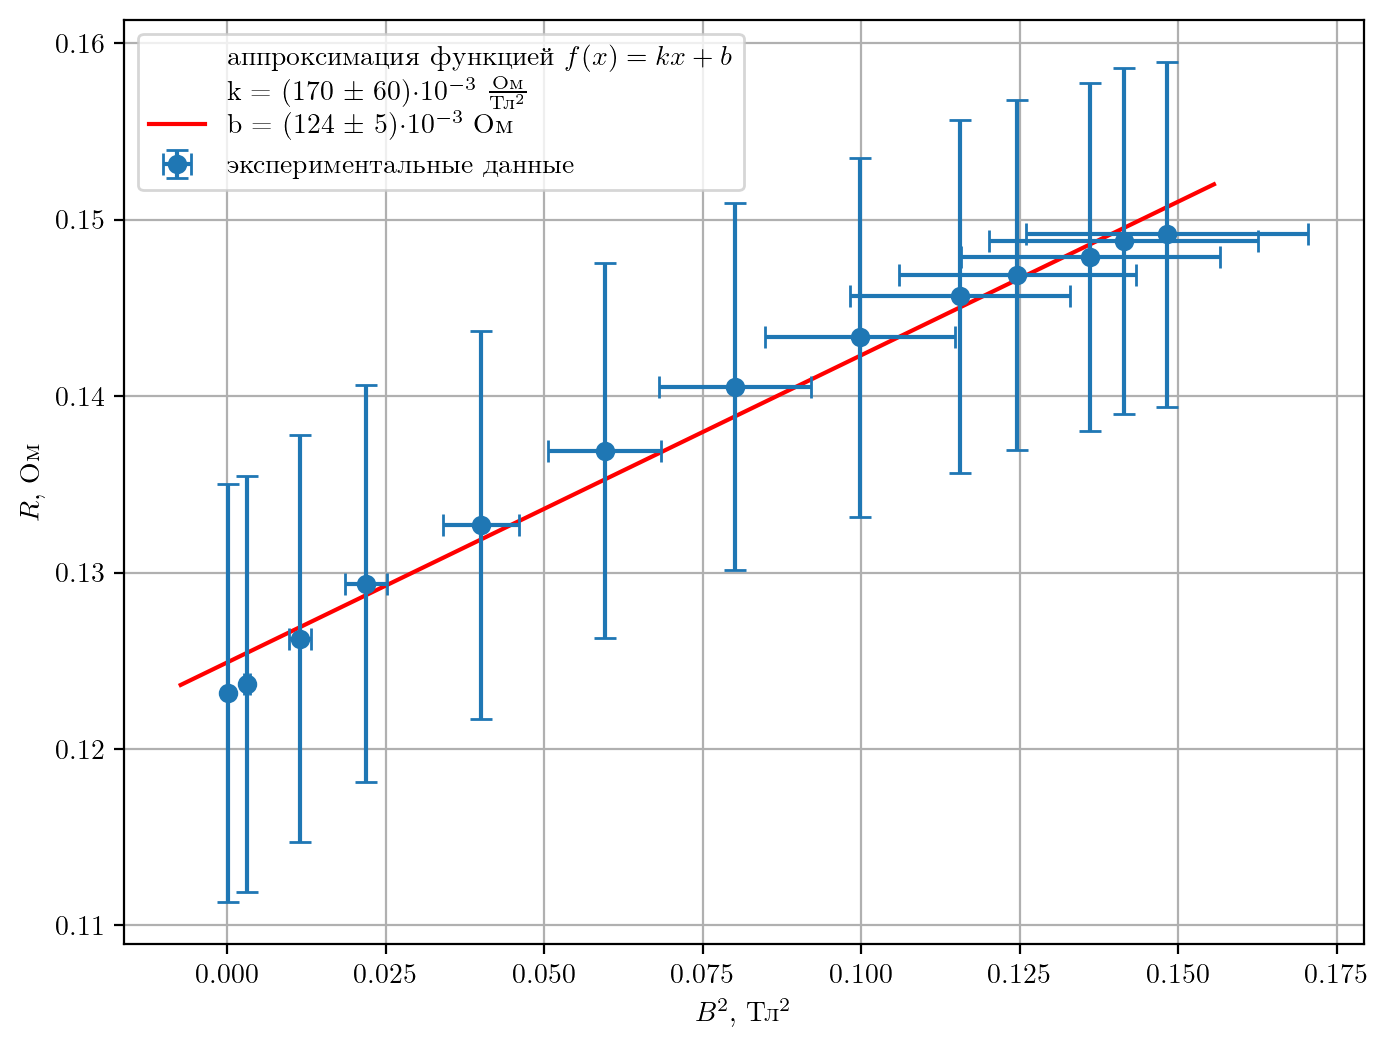

In [35]:
# параметры построения графика и аппроксмации прямой
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = False   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
xname, xunit = r"$B^2$", "$Тл^2$"
yname, yunit = r"$R$", "Ом"
par_names_str = fr'''
k, $\frac{{{yunit}}}{{{xunit.replace('$', '')}}}$
b, {yunit}
'''
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров
# построение графика

# аппроксимация
plot_approx(x, y, f, par_names_str, fun_name, yerr=yerr, visApproxError=visApproxError)

# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

make_beautiful_plot(xname, xunit, yname, yunit)
plt.title("")
if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1

#### Следующий график

In [36]:
#ВВод данных
df = pd.read_excel("hol_efect.ods", engine="odf", sheet_name=0) # для таблиц ods (требуется установка pip install odfpy)
# df = pd.read_excel("measurements.xls")    # excel таблицы
B = df.iloc[:, 1].dropna()/1000 # teslas
U = df.iloc[:, 16].dropna()/1000
I = 0.010
y = R = U/I
x = B**2
xerr = x*0.15
yerr = 5e-5*y + np.ones_like(x)*35e-6/U
df.head()

,"Ток через электромагнит, А","Магнитное поле, мТл",Unnamed: 2,"I_M, А","U, мВ","dU, мв",Ток постоянен и равен 24.0 мА,Unnamed: 7,Unnamed: 8,"U, мВ.1",Unnamed: 10,обратной стороной,Unnamed: 12,Перпендикулярно и параллельно полю(пластинка),"I_M, A","U_перп, мВ","U_пар, мВ"
0,0.00,-9.95,NaN,0.00,0.744,NaN,NaN,NaN,NaN,0.739,NaN,(примерно на 0.03 мВ можно уйти в пределах одн...,NaN,ток 10мА,0.00,2.956,2.704
1,0.05,-56.00,NaN,0.05,0.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,2.968,2.718
2,0.10,-107.40,NaN,0.10,0.998,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,0.10,3.030,2.758
3,0.15,-148.10,NaN,0.15,1.236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15,3.105,2.818
4,0.20,-200.00,NaN,0.20,1.572,NaN,NaN,NaN,NaN,1.682,NaN,NaN,NaN,NaN,0.20,3.185,2.888


0.13152681085188384 +- 0.06179208245693675
0.11404093110584564 +- 0.006005721033159358


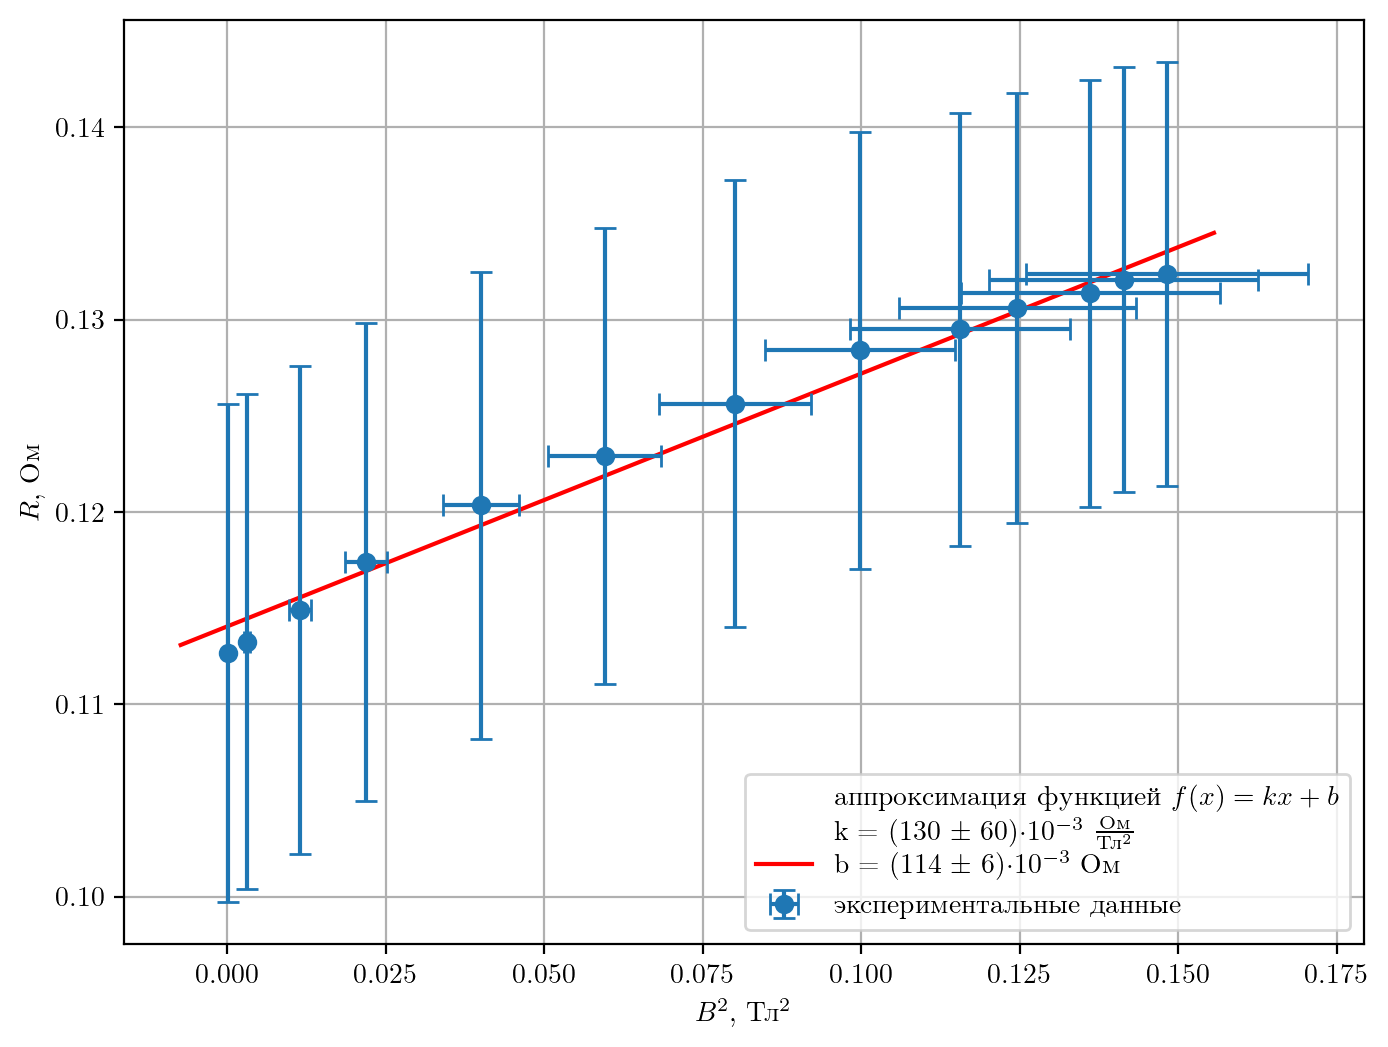

In [37]:
# параметры построения графика и аппроксмации прямой
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = False   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
xname, xunit = r"$B^2$", "$Тл^2$"
yname, yunit = r"$R$", "Ом"
par_names_str = fr'''
k, $\frac{{{yunit}}}{{{xunit.replace('$', '')}}}$
b, {yunit}
'''
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров
# построение графика

# аппроксимация
plot_approx(x, y, f, par_names_str, fun_name, yerr=yerr, visApproxError=visApproxError)

# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

make_beautiful_plot(xname, xunit, yname, yunit)
plt.title("")
if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1

### Все вместе

In [15]:
xname, xunit = r"$B^2$", "$Тл^2$"
yname, yunit = r"$R$", "Ом"
par_names_str = fr'''
k, $\frac{{{yunit}}}{{{xunit.replace('$', '')}}}$
b, {yunit}
'''
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x

hasErrors = True
xerr = None
yerr = None

# конец пользовательских параметров
# построение графика

0.8030266018064994 +- 0.00756979154811294
0.03309672127574432 +- 0.0007002529700478186
0.4231898199075859 +- 0.01819726075072735
0.2992968360963803 +- 0.001685117852414022
0.31890440111141777 +- 0.018188770343736796
0.27340650430016566 +- 0.0016844501940537161


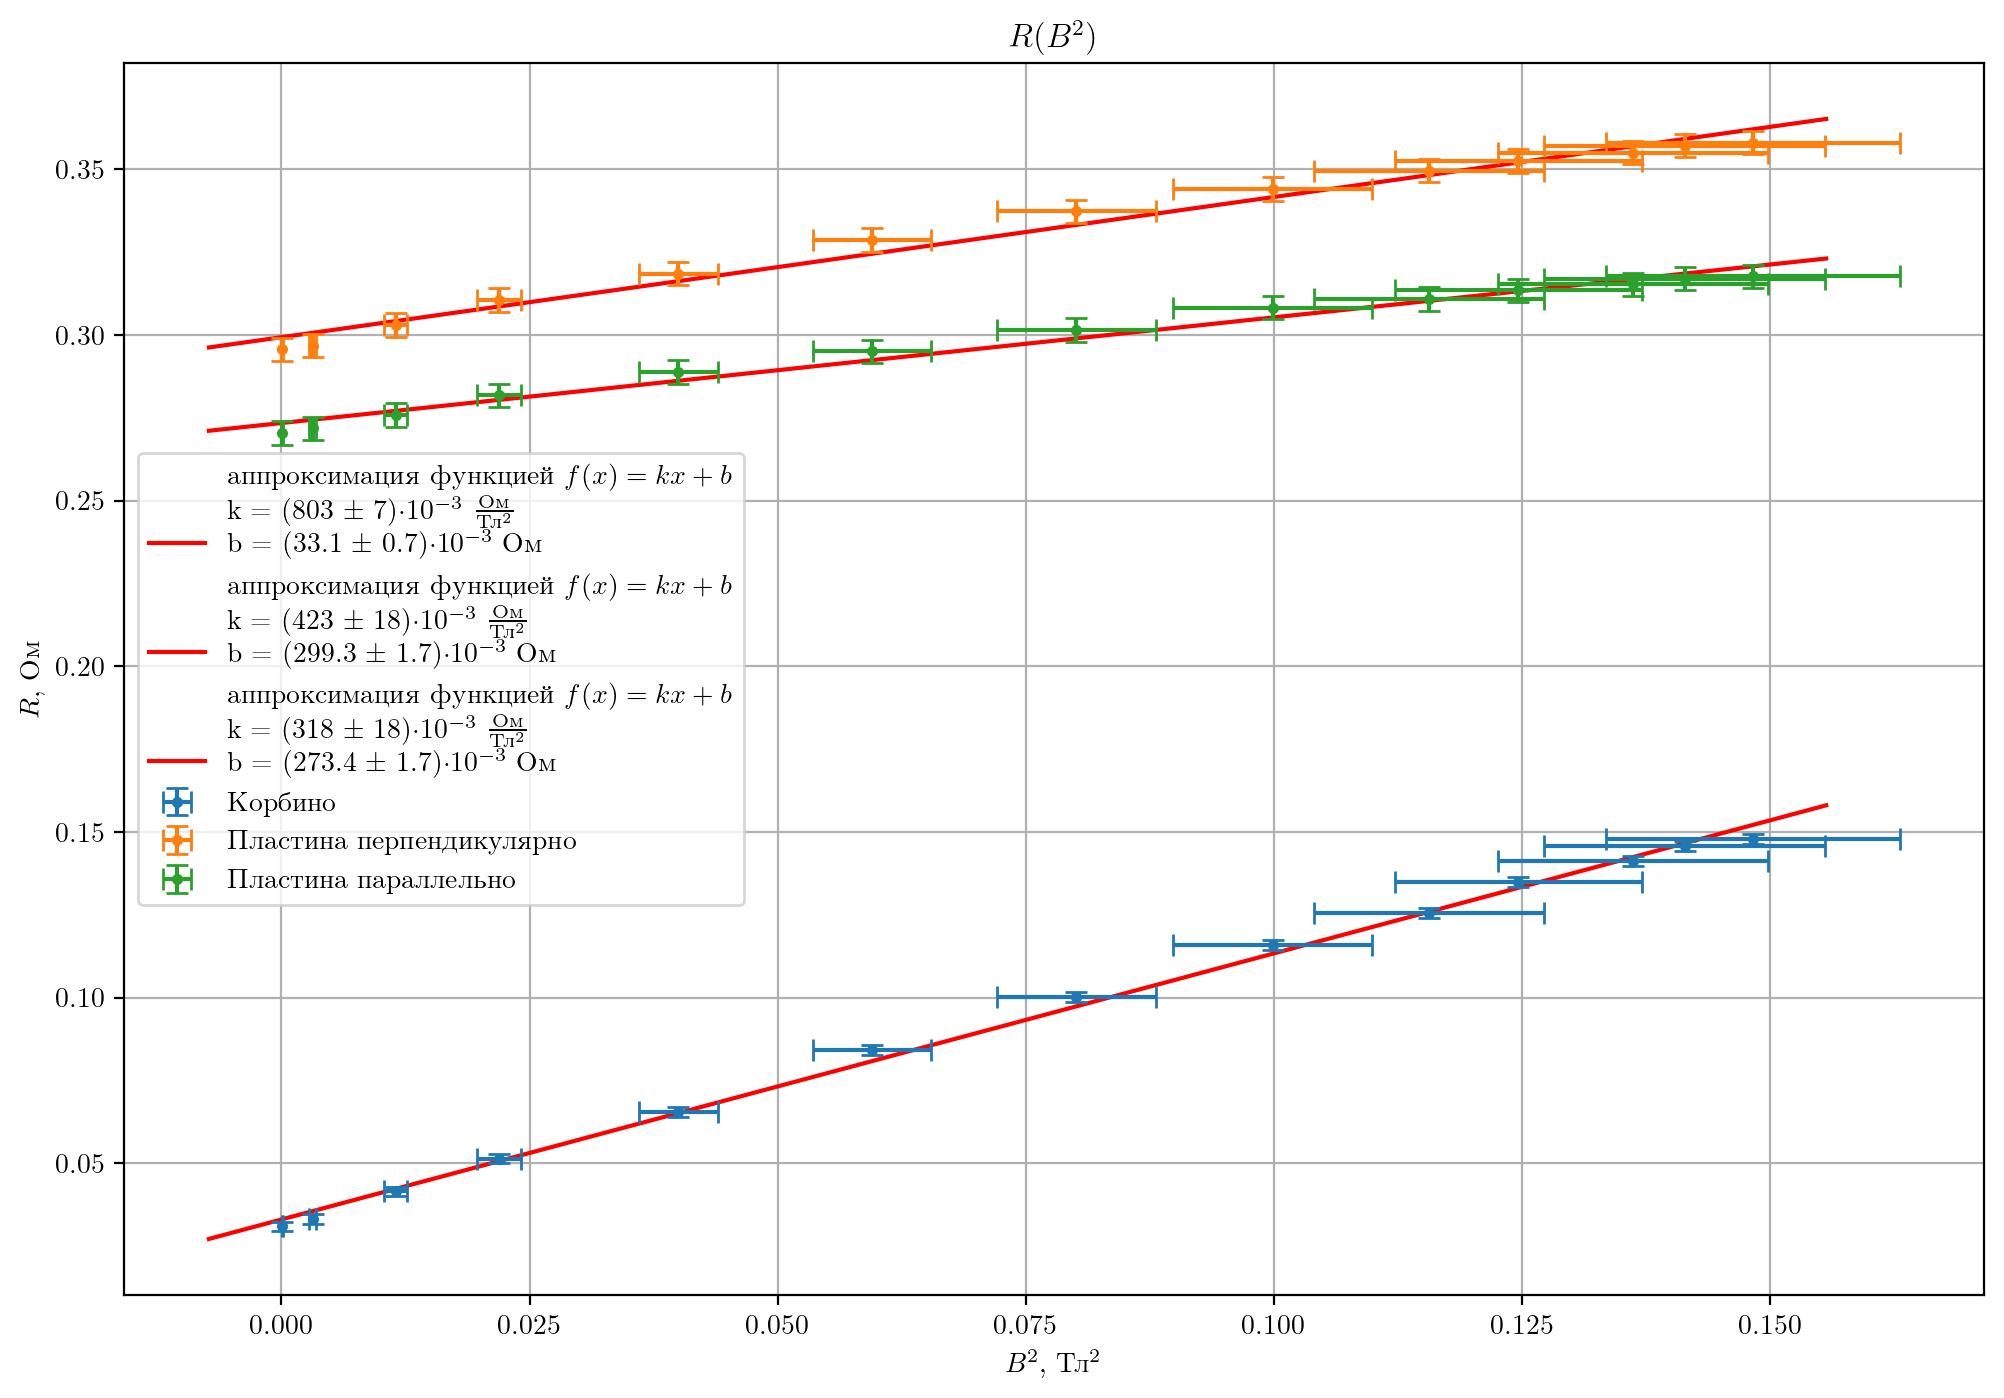

In [22]:
plt.figure(figsize=(12, 8))
#ВВод данных
df = pd.read_excel("hol_efect.ods", engine="odf", sheet_name=0) # для таблиц ods (требуется установка pip install odfpy)
# df = pd.read_excel("measurements.xls")    # excel таблицы
B = df.iloc[:, 1].dropna()/1000 # teslas
U = df.iloc[:, 4].dropna()/1000
I = 0.024
y = R = U/I
x = B**2
xerr = x*0.10
yerr = 5e-5*y + np.ones_like(x)*35e-6/I

# аппроксимация
plot_approx(x, y, f, par_names_str, fun_name, yerr=yerr, visApproxError=visApproxError)
# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="Корбино", capsize=4, ms=3)



B = df.iloc[:, 1].dropna()/1000 # teslas
U = df.iloc[:, 15].dropna()/1000
I = 0.010
y = R = U/I
x = B**2
xerr = x*0.10
yerr = 5e-5*y + np.ones_like(x)*35e-6/I
# аппроксимация
plot_approx(x, y, f, par_names_str, fun_name, yerr=yerr, visApproxError=visApproxError)
# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="Пластина перпендикулярно", capsize=4, ms=3)

B = df.iloc[:, 1].dropna()/1000 # teslas
U = df.iloc[:, 16].dropna()/1000
I = 0.010
y = R = U/I
x = B**2
xerr = x*0.10
yerr = 5e-5*y + np.ones_like(x)*35e-6/I
# аппроксимация
plot_approx(x, y, f, par_names_str, fun_name, yerr=yerr, visApproxError=visApproxError)
# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="Пластина параллельно", capsize=4, ms=3)





make_beautiful_plot(xname, xunit, yname, yunit)
if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1


In [18]:
# шаблон аппроксимации экспонентой
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика, 
название функции,
набор параметров с размерностями через запятую '''
visApproxError = True   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
xname, xunit = r"$t$", "с"
yname, yunit = r"$h$", "см"
par_names_str = fr'''
$f_0$, {yunit}
$\Delta f$, {yunit}
$T_0$, {xunit}
'''
# function to approximate
fun_name = r"$f(x) = f_0 + \Delta f e^{-x/T_0}$"
def f(x, f_0, df, T0):
    return f_0 + df*np.exp(-x/T0)
# конец пользовательских параметров
p0 = [y[0], y.max()-y.min(), (x.max()-x.min())/8]   # адекватное начальное приближение параметров

In [4]:
# параметры построения графика и аппроксмации относительно произвольной функцией
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика,
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = True   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
par_names_str = r'''
k,
b,
'''
xname, xunit = r"$x$", ""
yname, yunit = r"$y$", ""
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров

# Блоки для добавления в ячейку построения графика

In [ ]:
# выбор поднабора для построения на графике и аппроксимации
filter = x < 15000
x = x[filter]
y = y[filter]
xerr = xerr[filter]
yerr = yerr[filter]

In [ ]:
# опциональная загрузка данных разных измерений
N = 0 # номер измерения
stride = 3
x = df.iloc[:, stride*N+1].dropna()
y = df.iloc[:, stride*N+0].dropna()
xerr = np.ones_like(x)*0.1
yerr = np.ones_like(x)*1
label = df.iloc[:, stride*N+stride-2].name    # если он есть, его надо добавить в label errorbar'а
xname, xunit = x.name.split(', ')
yname, yunit = y.name.split(', ')

In [ ]:
plt.gca().set_xscale('log')